# Jacob's notebook wuup

In [181]:
from matplotlib import pyplot as plt
import numpy as np

## Pixel intensity distribution

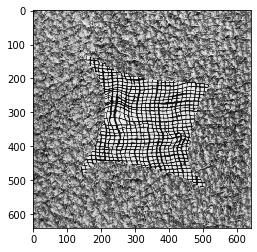

In [182]:
#fname = "data/simple_test.png"
fname = "data/overlap_test.png"
img = plt.imread(fname)
plt.imshow(img, cmap='gray')

In [183]:
def init_circle_curve(n_points, center, radius):
    th = np.arange(0,1,1/n_points)*(2*np.pi)
    snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
    return snake

def plot_snake(snake,col='blue'):
    plt.plot(*zip(*np.flip(snake,axis=1)),'.-',linewidth=1,color=col)
    
def plot_forces(snake, forces, factor):
    for i in range(len(snake)):
        d = forces[i,:]*factor
        plt.arrow(snake[i,1],snake[i,0],d[1],d[0], color='green')

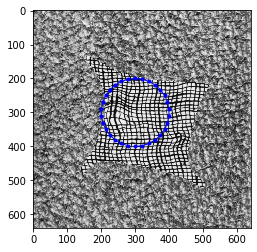

In [184]:
snake = init_circle_curve(30,(300,300),100)
plt.imshow(img, cmap='gray')
plot_snake(snake)

Find mask that describes the inner part of the snake:

In [185]:
def curve_normals(snake):
    a = np.zeros_like(snake)
    s_prev = np.roll(snake,  1, axis=0) # prev
    s_next = np.roll(snake, -1, axis=0) # next
    a[:,0] =   s_next[:,1] - s_prev[:,1]
    a[:,1] = -(s_next[:,0] - s_prev[:,0])
    a = a / np.linalg.norm(a, axis=1)[:,None]
    return a

In [186]:
from collections import deque

def pixels_between_points(p1, p2):
    vec = p2-p1
    l = np.linalg.norm(vec)
    p = np.arange(l)/l
    return (p1+p[:,None]*vec).astype(int)

def curve_contour(snake, mask_shape):
    mask = np.zeros(mask_shape).astype(bool)
    p = snake[-1,]
    for i in range(len(snake)):
        idx = pixels_between_points(p, snake[i,])
        p = snake[i,]
        mask[idx[:,0],idx[:,1]] = True
    return mask

def fill_contour(mask, seed):
    queue = deque([seed])
    while(queue):
        pt = queue.popleft()
        if(mask[pt[0],pt[1]] != True):
            mask[pt[0],pt[1]] = True
            # add neighbours to queue
            queue.append( (pt[0] - 1, pt[1]) )
            queue.append( (pt[0] + 1, pt[1]) )
            queue.append( (pt[0], pt[1] - 1) )
            queue.append( (pt[0], pt[1] + 1) )           
        
def snake_enclosed(snake, normals, img_shape):
    mask = curve_contour(snake, img_shape)
    p0 = tuple((snake[0,]-2*normals[0,]).astype(int))
    fill_contour(mask,p0)
    return mask.astype(bool)

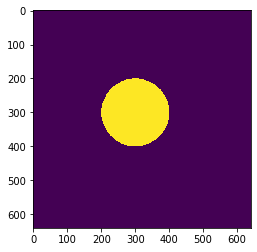

In [190]:
from skimage import draw

normals = curve_normals(snake)
mask = draw.polygon2mask(img.shape[:2], snake)
#mask = snake_enclosed(snake, normals, img.shape)
plt.imshow(mask)

Find which pixels intensities are found inside and outside the snake

In [191]:
all_unique = np.unique(img.flatten()) # array containing each different pixel value

count_inside = np.zeros_like(all_unique)
count_outside = np.zeros_like(all_unique)
count_total = np.zeros_like(all_unique)
var = np.zeros_like(all_unique)
for i,x in enumerate(all_unique):
    count_inside[i] = (img[mask]==x).sum()
    count_outside[i] = (img[~mask]==x).sum()
    count_total[i] = count_inside[i]+count_outside[i];
    idx = np.argwhere(img==x)
    mean = idx.mean(axis=0)
    var[i] = np.linalg.norm(idx - mean, axis=1).mean() # Average distance from each pxiel the center

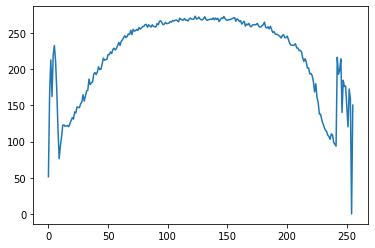

In [192]:
plt.plot(var)

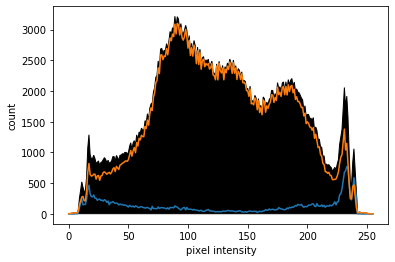

In [193]:
plt.fill(count_total, color='black')
plt.plot(count_inside)
plt.plot(count_outside)
plt.xlabel('pixel intensity')
plt.ylabel('count')
plt.show()

Scale according to inside/outside area

In [194]:
total_inside = mask.sum()
total_outside = img.size - total_inside
pixel_prc_in = count_inside/total_inside
pixel_prc_out = count_outside/total_outside

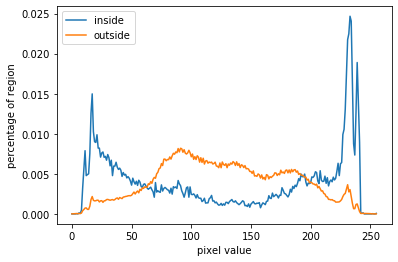

In [195]:
plt.plot(pixel_prc_in)
plt.plot(pixel_prc_out)
plt.xlabel('pixel value')
plt.ylabel('percentage of region')
plt.legend(['inside','outside'])
plt.show()

Calculate probalility of being inside contour based on pixel intensity

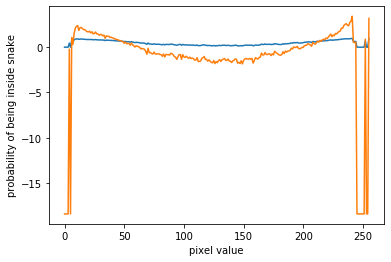

In [202]:
pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
pixel_probs_new = np.log(pixel_prc_in / (pixel_prc_out+1e-8)+1e-8)
plt.plot(pixel_probs)
plt.plot(pixel_probs_new)
plt.xlabel('pixel value')
plt.ylabel('probability of being inside snake')
plt.show()

Plot as probability image

In [143]:
prob_img = np.zeros_like(img)
for i,x in enumerate(all_unique):
    prob_img[img==x] = pixel_probs[i]

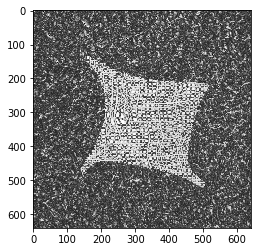

In [144]:
plt.imshow(prob_img, cmap='gray')

Reduce noie by snoothing

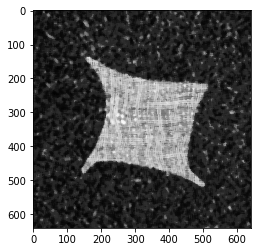

In [145]:
import scipy.ndimage as ndimage
#prob_img_smooth = ndimage.gaussian_filter(prob_img, sigma=(3, 3), order=0)
prob_img_smooth = ndimage.median_filter(prob_img, size=10)
#prob_img_smooth = ndimage.filters.convolve(prob_img , np.full((13, 13), 1.0/9))

# TODO Normalize ?

plt.imshow(prob_img_smooth, cmap='gray')

## Deform model on smoothed prob image

#### Wrap code in methods

In [146]:
from collections import deque
import snake_functions as sf
from skimage.transform import resize
#import importlib
#importlib.reload(sf)

class deform_model():
    def __init__(self,n_points, center, radius, smooth_param):
        th = np.arange(0,1,1/n_points)*(2*np.pi)
        self.snake = np.array([np.cos(th), np.sin(th)]).transpose()*radius + center
        self.normals = self.compute_normals()
        self.smooth_mat = sf.smooth_matrix(n_points, smooth_param[0], smooth_param[1])

    def compute_normals(self):
        a = np.zeros_like(self.snake)
        s_prev = np.roll(self.snake,  1, axis=0) # prev
        s_next = np.roll(self.snake, -1, axis=0) # next
        a[:,0] =   s_next[:,1] - s_prev[:,1]
        a[:,1] = -(s_next[:,0] - s_prev[:,0])
        a = a / np.linalg.norm(a, axis=1)[:,None]
        return a
    
    def read_values(self,img):
        idx_xy = self.snake.astype(int)
        return (img[idx_xy[:,0], idx_xy[:,1]])

    def set_forces(self, forces):
        self.force_vecs = forces[:,None] * self.normals
        
    def update(self, step_size, img_shape):
        self.snake += self.force_vecs*step_size
        self.regularize()
        # Prevent exceeding image boundaries:
        np.clip(model.snake[:,0], 0, img_shape[0]-1, out=model.snake[:,0])
        np.clip(model.snake[:,1], 0, img_shape[1]-1, out=model.snake[:,1])
        self.normals = self.compute_normals()
        
    def regularize(self):
        self.snake[:,:] = self.smooth_mat.dot(self.snake)
        snakeT = sf.distribute_points(self.snake.T)
        snakeT = sf.remove_intersections(snakeT)
        self.snake[:,:] = snakeT.T
    '''
    def enclosed_mask(self, img_shape, down_samp = 1):
        if(down_samp>1):
            mask_shape = tuple(np.divide(img_shape, down_samp).astype(int))
            snake = self.snake/4
        else:
            mask_shape = img_shape
            snake = self.snake

        mask = curve_contour(snake, mask_shape)
        p0 = tuple((snake[0,]-2*self.normals[0,]).astype(int))
        fill_contour(mask,p0)
        
        if(down_samp>1):
            mask = resize(mask, img_shape, order = 0, preserve_range=True)
            
        return mask.astype(bool)
    '''
    
    def enclosed_mask(self, img_shape, down_samp = 1):
        '''
        Creates a (down sampled) region of interest around the snake, 
        marks all pixels under the contour and flood fills its surrondings.
        The mask is then upsampled and padded to match the full scale image.
        '''
        snake = self.snake / down_samp

        # Find rectangle around contour
        r_min = snake[:,0].min().astype(int)
        c_min = snake[:,1].min().astype(int)
        r_max = snake[:,0].max().astype(int)
        c_max = snake[:,1].max().astype(int)

        rows = r_max-r_min
        cols = c_max-c_min

        pad = 3
        mask = np.ones((rows+2*pad, cols+2*pad), dtype=bool) # create region of interest with some padding
        mask[:,[0,-1]] = mask[[0,-1]] = False # mark edges to create boundary

        # Mark all point under the snake countour
        snake = snake - [r_min,c_min] + pad
        p = snake[-1,]
        for i in range(len(snake)):
            idx = sf.pixels_between_points(p, snake[i,])
            p = snake[i,]
            mask[idx[:,0],idx[:,1]] = False

        sf.fill_contour(mask, [1,1], value=False) # flood fill area between countour and edges
        mask = mask[pad:-pad, pad:-pad] # remove padding
        if(down_samp>1):
            mask = resize(mask, (down_samp*rows, down_samp*cols), order = 0, preserve_range=True)

        full_mask = np.zeros((img_shape), dtype=bool)
        full_mask[down_samp*r_min:down_samp*r_max, down_samp*c_min:down_samp*c_max] = mask.astype(bool)
        return full_mask


In [147]:
def create_prob_image(img, mask, filter_size=10, return_probs=False):    
    all_unique = np.unique(img.flatten()) # array containing each different pixel value

    count_inside = np.zeros_like(all_unique)
    count_outside = np.zeros_like(all_unique)
    count_total = np.zeros_like(all_unique)
    for i,x in enumerate(all_unique):
        count_inside[i] = (img[mask]==x).sum()
        count_outside[i] = (img[~mask]==x).sum()
        count_total[i] = count_inside[i]+count_outside[i]
        
    total_inside = mask.sum()
    total_outside = img.size - total_inside
    pixel_prc_in = count_inside/total_inside
    pixel_prc_out = count_outside/total_outside
    
    pixel_probs = pixel_prc_in / (pixel_prc_in+pixel_prc_out)
    
    prob_img = np.zeros_like(img, dtype=float)
    for i,x in enumerate(all_unique):
        prob_img[img==x] = pixel_probs[i]
#    prob_img = ndimage.gaussian_filter(prob_img, sigma=(5, 5), order=0)
    prob_img = ndimage.median_filter(prob_img, size=filter_size)

    if return_probs: 
        return prob_img, pixel_probs
    else:
        return prob_img

#### Open cv draw methods

In [148]:
import cv2

def draw_snake(img_out, snake, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    pt0 = snake[-1,:].astype(int)
    for i in range(len(snake)):
        pt1 = snake[i,:].astype(int)
        img_out = cv2.line(img_out, tuple(pt0), tuple(pt1), color, 1)
        img_out = cv2.circle(img_out, tuple(pt1), 2, color, cv2.FILLED, 1)
        pt0 = pt1
    return img_out 

def draw_forces(img_out, snake, forces, color=(255,0,0)):
    snake = np.flip(snake,axis=1)
    forces = np.flip(forces,axis=1)
    for i in range(len(snake)):
        pt = snake[i,:]
        pt2 = snake[i,:] + forces[i,]
        img_out = cv2.arrowedLine(img_out, tuple(pt.astype(int)), tuple(pt2.astype(int)), color, 1)
    return img_out 

def vis_snake(img, snake, forces={}, wait=30, color=(255,0,0), title="snake"):
    if img.ndim==2:
        img_out = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    else:
        img_out = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

    img_out = draw_snake(img_out, snake, color)
    if len(forces)>0:
        img_out = draw_forces(img_out, snake, forces, color=color)
    cv2.imshow(title, img_out)
    key = cv2.waitKey(wait)
    return key==27


#### Run

In [149]:
model = deform_model(n_points = 140, center = (200,300), radius = 100, smooth_param=(0.2,0.2))

step_size = 100

i = 0
while(True):
    if(i%5==0):
        mask = model.enclosed_mask(img.shape, down_samp=4)
        prob_img = create_prob_image(img, mask)
    model.set_forces(model.read_values(prob_img) - 0.5)
    
    # Visualize
    cv2.imshow("mask", mask.astype(float))
    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img.astype('float32'), model.snake, 200*model.force_vecs, wait=30, title="Probability"):
        break
    
    model.update(step_size, img.shape)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);

# Creating patch dictionary

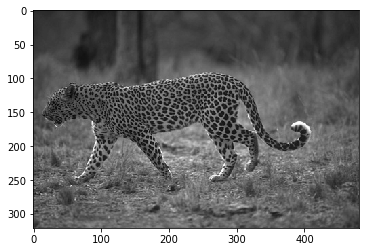

In [150]:
fname = "data/134052.jpg"
img = cv2.imread(fname, cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray')

In [151]:
# returns flattened image patches from image A of shape BSZ
def im2col(A, BSZ, stepsize=1):
    # Parameters
    m,n = A.shape
    s0, s1 = A.strides
    nrows = m-BSZ[0]+1
    ncols = n-BSZ[1]+1
    shp = BSZ[0],BSZ[1],nrows,ncols
    strd = s0,s1,s0,s1

    out_view = np.lib.stride_tricks.as_strided(A, shape=shp, strides=strd)
    return out_view.reshape(BSZ[0]*BSZ[1],-1)[:,::stepsize]

Collapse image patches into vector features

In [152]:
E = 3
K = 1+2*E
patch_size = (K,K)
features = im2col(img, patch_size).transpose()
new_shape = tuple(np.array(img.shape) - (2*E))
print(features.shape)

(149625, 49)


Divide features into clusters (using just a sample to speed up the process)

In [153]:
import sklearn.cluster

samp_size = 5000
clusters = 100
sample_idx = np.random.permutation(features.shape[0])[:samp_size]
feature_sample = features[sample_idx,:]
kmeans = sklearn.cluster.KMeans(n_clusters=clusters, verbose=False).fit(feature_sample)

In [154]:
predicted_clusters = kmeans.predict(features)

In [155]:
cluster_img = predicted_clusters.reshape(img.shape[0]-2*E, img.shape[1]-2*E)
img = img[E:-E, E:-E] # crop image to match shapes

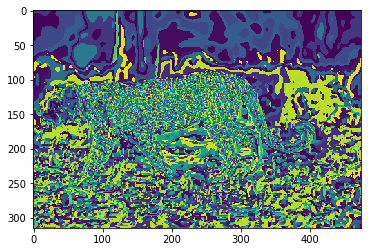

In [156]:
plt.imshow(cluster_img)

Since the clusters have random colors there's not a lot to see

In [157]:
def plot_dictionary(cluster_centers, rows, cols, patch_shape=(), highlight=None, spacing=3):
    if(patch_shape==()):
        s = int(np.sqrt(cluster_centers.shape[1]))
        patch_shape = (s,s)

    h = patch_shape[0]+spacing
    w = patch_shape[1]+spacing
    dict_img = np.zeros((rows*w + spacing, cols*w + spacing, 3), dtype='uint8')

    cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1])
    if(highlight is not None): highlight = highlight.reshape(rows,cols)

    for r in range(rows):
        for c in range(cols):
            y = spacing + r*h
            x = spacing + c*w
            if(highlight is not None):
                p = highlight[r,c]
                dict_img[y-1:y+patch_shape[0]+1, x-1:x+patch_shape[1]+1, :] = [-p*(p<0)*255, p*(p>0)*255, 0]
                
            dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,None]            
                
    plt.imshow(dict_img, cmap='gray')

In [158]:
def layout_dictionary(cluster_centers, rows, cols, patch_shape=(), color=False, highlight=None, spacing=3):
    if(patch_shape==()):
        s = int(np.sqrt(cluster_centers.shape[1]/(1+2*color)))
        patch_shape = (s,s)

    h = patch_shape[0]+spacing
    w = patch_shape[1]+spacing
    dict_img = np.zeros((rows*w + spacing, cols*w + spacing, 3), dtype='uint8')

    if(color):
        cluster_centers = cluster_centers.reshape(rows,cols,3,patch_shape[0],patch_shape[1])
        cluster_centers = np.moveaxis(cluster_centers, -3, -1) # move color axis to last dim, (r,c,3,ps,ps) -> (r,c,ps,ps,3)
    else:
        cluster_centers = cluster_centers.reshape(rows,cols,patch_shape[0],patch_shape[1])

    if(highlight is not None): highlight = highlight.reshape(rows,cols)

    for r in range(rows):
        for c in range(cols):
            y = spacing + r*h
            x = spacing + c*w
            if(highlight is not None):
                p = highlight[r,c]
                dict_img[y-1:y+patch_shape[0]+1, x-1:x+patch_shape[1]+1, :] = [-p*(p<0)*255, p*(p>0)*255, 0]
                
            if(color):
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,]
            else:
                dict_img[y:y+patch_shape[0], x:x+patch_shape[1], ] = cluster_centers[r,c,:,:,None]
    
    return dict_img

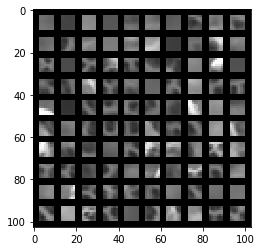

In [159]:
dict_img = layout_dictionary(kmeans.cluster_centers_, 10,10);
plt.imshow(dict_img)

__Create probability image from the cluster distribution, just as with the pixel intensities__

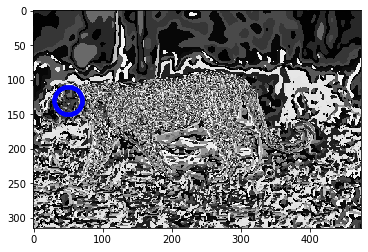

In [160]:
#model = deform_model(n_points = 140, center = (130,200), radius = 40, smooth_param=(0,0))
model = deform_model(n_points = 140, center = (130,50), radius = 20, smooth_param=(0.05,0.1))

plt.imshow(cluster_img, cmap='gray')
plot_snake(model.snake)

In [161]:
def colorize_prob_img(prob_img, channels=(1,0)):
    prob_img_color = np.zeros(prob_img.shape+(3,), dtype='uint8')
    prob_img_color[:,:,channels[0]] =  prob_img*(prob_img > 0) * 255
    prob_img_color[:,:,channels[1]] = -prob_img*(prob_img < 0) * 255
    return prob_img_color

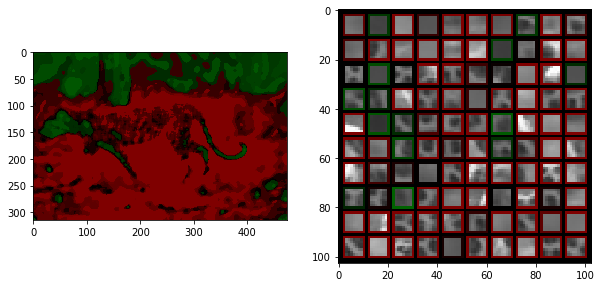

In [162]:
mask = model.enclosed_mask(cluster_img.shape, down_samp=4)
prob_img, probs = create_prob_image(cluster_img,mask, return_probs=True)
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(colorize_prob_img(prob_img-0.5), cmap='gray')
plt.subplot(1,2,2)
dict_img = layout_dictionary(kmeans.cluster_centers_, 10,10, highlight=probs-0.5);
plt.imshow(dict_img)

#### Run again!

In [163]:
step_size = 10

i = 0
while(True):
    if(i%5==0):
        mask = model.enclosed_mask(cluster_img.shape, down_samp=1)
        prob_img = create_prob_image(cluster_img, mask, filter_size=10)
        prob_img_color = colorize_prob_img(prob_img-0.5, channels=(1,2))
        
    model.set_forces(model.read_values(prob_img) - 0.5)
    
    # Visualize
    cv2.imshow("mask", mask.astype(float))
    cv2.imshow("color probs", prob_img_color)

    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img.astype('float32'), model.snake, 3*step_size*model.force_vecs, wait=30, title="Probability"):
        break
    
    model.update(step_size, img.shape)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);

### Including variance in prob image (not implemented)

In [164]:
all_unique = np.unique(cluster_img.ravel()) # array containing each different pixel value

count_inside = np.zeros_like(all_unique)
count_outside = np.zeros_like(all_unique)
count_total = np.zeros_like(all_unique)
var_in =  np.zeros_like(all_unique, dtype=float)
var_out =  np.zeros_like(all_unique, dtype=float)
for i,x in enumerate(all_unique):
    count_inside[i] = (cluster_img[mask]==x).sum()
    count_outside[i] = (cluster_img[~mask]==x).sum()
    count_total[i] = count_inside[i]+count_outside[i]

#    idx = np.argwhere(cluster_img==x)
    idx = np.argwhere(np.logical_and(mask, cluster_img==x)) 
    if(len(idx>0)):
        mean = idx.mean(axis=0)
        var_in[i] = np.linalg.norm(idx - mean, axis=1).mean() # Average distance from each pxiel to the center
    else:
        var_in[i] = 0
        
    idx = np.argwhere(np.logical_and(~mask, cluster_img==x)) 
    if(len(idx>0)):
        mean = idx.mean(axis=0)
        var_out[i] = np.linalg.norm(idx - mean, axis=1).mean() # Average distance from each pxiel to the center
    else:
        var_out[i] = 0


58


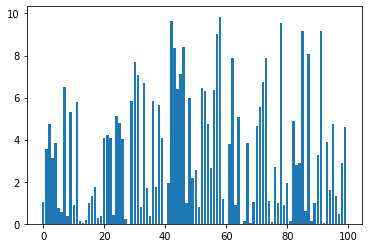

In [165]:
conentration = count_inside / (var_in+1)
plt.bar(range(100),count_inside / (var_in+1))
print(conentration.argmax())

In [166]:
print(count_inside[31])
print(var_in[31])

565
78.61203492891013


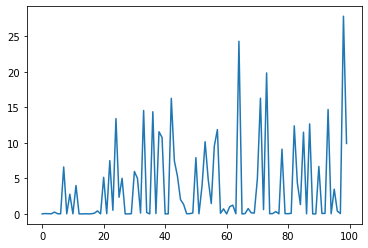

In [167]:
plt.plot(count_inside/count_outside)

In [168]:
len(np.argwhere(np.logical_and(mask, cluster_img==1)) )
#np.argwhere(cluster_img[mask]==5)

302

<BarContainer object of 100 artists>

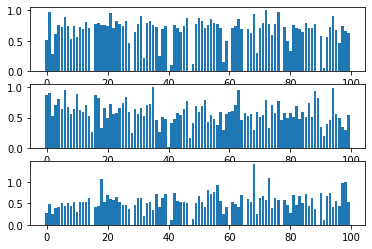

In [169]:
f = plt.figure()
f.add_subplot(311)
plt.bar(range(100),var_in / var_in.max())
f.add_subplot(312)
plt.bar(range(100),var_out / var_out.max())
f.add_subplot(313)
plt.bar(range(100),var_in / var_out)

In [170]:
(var_in / var_out).argmin()

15

## Color

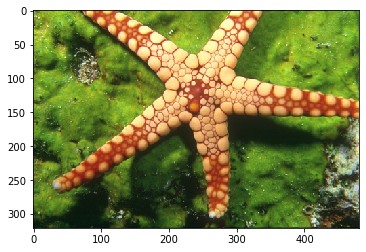

In [171]:
#fname = "data/134052.jpg"
fname = "data/12003.jpg"
img = plt.imread(fname)
plt.imshow(img)

In [172]:
def ndim2col(A, BSZ, stepsize=1):
    if(A.ndim == 2):
        return im2col(A, BSZ, stepsize)
    else:
        r,c,l = A.shape
        patches = np.zeros((l*BSZ[0]*BSZ[1],(r-BSZ[0]+1)*(c-BSZ[1]+1)))
        for i in range(l):
            patches[i*BSZ[0]*BSZ[1]:(i+1)*BSZ[0]*BSZ[1],:] = im2col(A[:,:,i],BSZ,stepsize)
        return patches

(149625, 147)


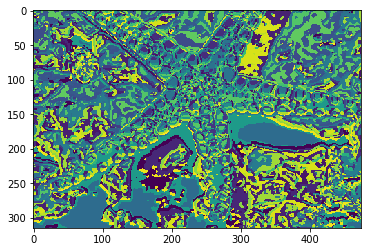

In [173]:
E = 3
K = 1+2*E
patch_size = (K,K)
features = ndim2col(img, patch_size).transpose()
print(features.shape)

samp_size = 5000
clusters = 100
sample_idx = np.random.permutation(features.shape[0])[:samp_size]
feature_sample = features[sample_idx,:]
kmeans = sklearn.cluster.KMeans(n_clusters=clusters, verbose=False).fit(feature_sample)

predicted_clusters = kmeans.predict(features)
cluster_img = predicted_clusters.reshape(img.shape[0]-2*E, img.shape[1]-2*E)
img = img[E:-E, E:-E] # crop image to match shapes
plt.imshow(cluster_img)

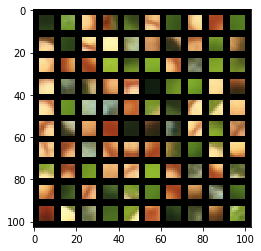

In [174]:
dict_img = layout_dictionary(kmeans.cluster_centers_, 10,10, color=True)
plt.imshow(dict_img)

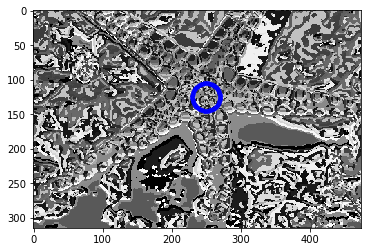

In [178]:
#model = deform_model(n_points = 140, center = (130,200), radius = 40, smooth_param=(0,0)) # leo body
#model = deform_model(n_points = 140, center = (130,50), radius = 20, smooth_param=(0.05,0.1)) # leo head
model = deform_model(n_points = 140, center = (125,250), radius = 20, smooth_param=(0.05,0.1)) # start


plt.imshow(cluster_img, cmap='gray')
plot_snake(model.snake)

In [180]:
step_size = 10

i = 0
while(True):
    if(i%5==0):
        mask = model.enclosed_mask(cluster_img.shape, down_samp=1)
        prob_img, probs = create_prob_image(cluster_img, mask, filter_size=10, return_probs=True)
        prob_img_color = colorize_prob_img(prob_img-0.5, channels=(1,2))
        
        dict_img = layout_dictionary(kmeans.cluster_centers_, 10,10, color=True, highlight=probs-0.5)
        dict_img = ndimage.zoom(dict_img, (3, 3, 1), order=0)
        dict_img = cv2.cvtColor(dict_img,cv2.COLOR_RGB2BGR)

    model.set_forces(model.read_values(prob_img) - 0.5)
    
    # Visualize
    cv2.imshow("mask", mask.astype(float))
    cv2.imshow("color probs", prob_img_color)
    cv2.imshow("dictionary",dict_img)


    vis_snake(img, model.snake, wait=1, title="Original")
    if vis_snake(prob_img.astype('float32'), model.snake, 3*step_size*model.force_vecs, wait=30, title="Probability"):
        break
    
    model.update(step_size, img.shape)
    i+=1
    
cv2.destroyAllWindows()
cv2.waitKey(1);